# Гипотезы и предложения

1. Большинство создаваемых гильдий не активны.
2. Игроки, покупающие премиум товары, создают более активные гильдии, поскольку, инвестируя в игру, пользователь больше ценит вложенные усилия.  
3. Если первое предположение верно, стоит ли существенно повысить стоимость создания гильдии, в том числе сделать это премиум товаром (за реальные деньги)?

## Гипотеза 1: большинство создаваемых гильдий не активны

Сначала определим нестрогие критерии (факторы) активности гильдии. Ниже будет выбран метод распредления гильдий по классам активности согласно этим критериям.

### Критерий неактивной гильдии

1. Низкое число игроков
2. Низкое число полученной энергии
3. Низкое число открытых талантов
4. Низкий уровень

### Критерий активной гильдии

1. Выское число полученной энергии
2. Открытые таланты
3. Высокий уровень
4. Выполненые миссии
5. Участие в войне гильдий

## Шаг 0: Загрузка и предобработка данных

Загрузим датасеты и обработаем их

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import mannwhitneyu

### Загрузим guild_data.csv

In [3]:
guild_data = pd.read_csv('guild_data.csv')
guild_data.head()

,datetime,creator_character_id,guild_id,n_added_characters,n_removed_characters,n_talents,level,n_missions_completed,n_times_flag_turned_on,mean_place,mean_rating,n_seasons
0,2022-12-12 23:13:42,15092203,78698,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-12 22:29:09,15961764,78604,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-12 21:01:53,16187808,78510,27,19.0,9.0,2.0,171.0,NaN,NaN,NaN,NaN
3,2022-12-12 00:16:52,21618959,77899,42,35.0,12.0,3.0,171.0,NaN,NaN,NaN,NaN
4,2022-12-12 22:13:50,23341705,78557,6,6.0,4.0,2.0,156.0,NaN,NaN,NaN,NaN


Посмотрим на типы данных в датафрейме

In [4]:
guild_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   datetime                965 non-null    object 
 1   creator_character_id    965 non-null    int64  
 2   guild_id                965 non-null    int64  
 3   n_added_characters      965 non-null    int64  
 4   n_removed_characters    866 non-null    float64
 5   n_talents               672 non-null    float64
 6   level                   572 non-null    float64
 7   n_missions_completed    895 non-null    float64
 8   n_times_flag_turned_on  81 non-null     float64
 9   mean_place              59 non-null     float64
 10  mean_rating             59 non-null     float64
 11  n_seasons               59 non-null     float64
dtypes: float64(8), int64(3), object(1)
memory usage: 90.6+ KB


Заполним пропуски и исправим типы данных на целочисленные.    
Если уровень гильдии не менялся, то он равен 1.   
Остальные значения должны быть равны 0.   

In [5]:
guild_data.describe()

,creator_character_id,guild_id,n_added_characters,n_removed_characters,n_talents,level,n_missions_completed,n_times_flag_turned_on,mean_place,mean_rating,n_seasons
count,9.650000e+02,965.000000,965.000000,866.000000,672.000000,572.000000,895.000000,81.000000,59.000000,59.000000,59.000000
mean,2.323599e+07,72964.000000,32.888083,31.047344,15.422619,3.097902,137.645810,1.839506,15.024294,475.078814,1.508475
std,3.926890e+06,13099.642839,36.893785,34.651878,15.254326,1.176624,65.121816,1.427032,7.262593,52.528824,0.989129
min,1.063135e+07,50310.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.500000,320.000000,1.000000
25%,2.114097e+07,61637.000000,4.000000,5.000000,6.000000,2.000000,86.000000,1.000000,10.000000,445.250000,1.000000
50%,2.395866e+07,72964.000000,20.000000,19.000000,11.000000,3.000000,169.000000,1.000000,14.000000,477.000000,1.000000
75%,2.631834e+07,84291.000000,49.000000,47.000000,20.000000,4.000000,171.000000,2.000000,18.500000,500.000000,2.000000
max,2.909053e+07,95618.000000,283.000000,265.000000,109.000000,8.000000,279.000000,8.000000,35.000000,604.000000,5.000000


In [6]:
guild_data['n_removed_characters'].fillna(0, inplace=True)
guild_data['n_talents'].fillna(0, inplace=True)
guild_data['level'].fillna(1, inplace=True)
guild_data['n_missions_completed'].fillna(0, inplace=True)
guild_data['n_times_flag_turned_on'].fillna(0, inplace=True)
guild_data['n_seasons'].fillna(0, inplace=True)

#guild_data['mean_place'].fillna(0, inplace=True)
guild_data['mean_rating'].fillna(0, inplace=True)

In [7]:
guild_data[['n_removed_characters', 'n_talents', 'level', \
            'n_missions_completed', 'n_times_flag_turned_on', 'n_seasons']] = \
guild_data[['n_removed_characters', 'n_talents', 'level', \
            'n_missions_completed', 'n_times_flag_turned_on', 'n_seasons']].astype('int64', False)

Добавим новую колонку -- текущее количество персонажей

In [8]:
guild_data['n_characters'] = guild_data['n_added_characters'] - guild_data['n_removed_characters']

Теперь мы можем узнать число гильдий без персонажей.

In [9]:
guild_data[guild_data['n_characters'] == 0].shape[0]

219

### Загрузим energy.csv

In [10]:
energy = pd.read_csv('energy.csv')
energy.head()

,energy_delta,context_type,guild_id
0,1148686,GuildMissionRewardContext,90166
1,1018116,GuildMissionRewardContext,81283
2,907440,GuildMissionRewardContext,79262
3,889109,GuildMissionRewardContext,84667
4,858954,GuildMissionRewardContext,77241


In [31]:
energy.context_type.unique()

array(['GuildMissionRewardContext', 'CompleteGuildRaidMatchContext',
       'ConvertKnowledgeToGuildEnergyContext'], dtype=object)

Посмотрим на количество гильдий

In [11]:
energy['guild_id'].nunique()

841

Число гильдий здесь меньше, чем в первом файле. Возможно, что часть гильдий не заработала никакой энергии.

In [12]:
energy['context_type'].value_counts()

GuildMissionRewardContext               841
ConvertKnowledgeToGuildEnergyContext     77
CompleteGuildRaidMatchContext            53
Name: context_type, dtype: int64

Сгруппируем данные по гильдиям, чтобы получить общее кол-во энергии, полученное каждой гильдией.

In [13]:
energy_by_guild = energy.groupby('guild_id').agg({'energy_delta': 'sum'})
print(energy_by_guild.shape)
energy_by_guild.head()

(841, 1)


,energy_delta
guild_id,
50310,1960
50357,94280
50404,24680
50451,6440
50545,27060


Объединим данные в один датафрейм.

In [14]:
guild_data = guild_data.merge(energy_by_guild, how='left', on='guild_id')
guild_data.energy_delta.fillna(0, inplace=True)

Посмотрим на гильдии, не заработавшие никакой энергии.

In [15]:
guild_data[~guild_data['guild_id'].isin(energy['guild_id'])].describe()

,creator_character_id,guild_id,n_added_characters,n_removed_characters,n_talents,level,n_missions_completed,n_times_flag_turned_on,mean_place,mean_rating,n_seasons,n_characters,energy_delta
count,1.240000e+02,124.000000,124.000000,124.000000,124.0,124.0,124.000000,124.0,0.0,124.0,124.0,124.000000,124.0
mean,2.214774e+07,73965.024194,2.403226,2.088710,0.0,1.0,23.782258,0.0,NaN,0.0,0.0,0.314516,0.0
std,4.775135e+06,13603.192703,3.416648,3.549905,0.0,0.0,37.574979,0.0,NaN,0.0,0.0,0.616401,0.0
min,1.094399e+07,50498.000000,1.000000,0.000000,0.0,1.0,0.000000,0.0,NaN,0.0,0.0,0.000000,0.0
25%,1.876538e+07,61190.500000,1.000000,0.750000,0.0,1.0,0.000000,0.0,NaN,0.0,0.0,0.000000,0.0
50%,2.230980e+07,75596.000000,1.000000,1.000000,0.0,1.0,0.000000,0.0,NaN,0.0,0.0,0.000000,0.0
75%,2.630366e+07,85125.250000,2.000000,2.000000,0.0,1.0,85.000000,0.0,NaN,0.0,0.0,1.000000,0.0
max,2.889549e+07,95430.000000,17.000000,17.000000,0.0,1.0,87.000000,0.0,NaN,0.0,0.0,4.000000,0.0


In [16]:
guild_data.describe()

,creator_character_id,guild_id,n_added_characters,n_removed_characters,n_talents,level,n_missions_completed,n_times_flag_turned_on,mean_place,mean_rating,n_seasons,n_characters,energy_delta
count,9.650000e+02,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,965.000000,59.000000,965.000000,965.000000,965.000000,9.650000e+02
mean,2.323599e+07,72964.000000,32.888083,27.862176,10.739896,2.243523,127.661140,0.154404,15.024294,29.046269,0.092228,5.025907,7.364979e+04
std,3.926890e+06,13099.642839,36.893785,34.150792,14.570964,1.372436,72.172584,0.655327,7.262593,114.608182,0.435451,4.961507,1.982774e+05
min,1.063135e+07,50310.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.114097e+07,61637.000000,4.000000,2.000000,0.000000,1.000000,86.000000,0.000000,10.000000,0.000000,0.000000,1.000000,1.680000e+03
50%,2.395866e+07,72964.000000,20.000000,14.000000,7.000000,2.000000,168.000000,0.000000,14.000000,0.000000,0.000000,4.000000,1.658000e+04
75%,2.631834e+07,84291.000000,49.000000,44.000000,15.000000,3.000000,171.000000,0.000000,18.500000,0.000000,0.000000,8.000000,6.158000e+04
max,2.909053e+07,95618.000000,283.000000,265.000000,109.000000,8.000000,279.000000,8.000000,35.000000,604.000000,5.000000,23.000000,1.847185e+06


### Шаг 1: Кластеризация

Критерий активности выберем кластеризацией методом ближайший соседей. Так как метод считает расстояние между точками в пространстве признаков, их нужно нормировать (например, MinMax).

In [17]:
X = guild_data[['n_talents', 'level', 'n_missions_completed', 'n_characters', 'energy_delta']]
clustering = KMeans(n_clusters=4).fit(MinMaxScaler().fit_transform(X))
clustering.labels_
guild_data['cluster'] = pd.Series(clustering.labels_)

In [18]:
# 75-ый персентиль
def q3(x):
    return x.quantile(0.75)

Посмотрим на результаты кластеризации 

In [19]:
print(guild_data.cluster.value_counts())
guild_data[['n_talents', 'level', 'n_missions_completed', 'n_characters', 'energy_delta', 'cluster']].groupby('cluster').agg(['median', q3])

3    418
1    364
0    155
2     28
Name: cluster, dtype: int64


n_talents         level      n_missions_completed          \
           median     q3 median   q3               median      q3   
cluster                                                             
0            25.0  31.00    4.0  4.0                175.0  218.00   
1             0.0   0.00    1.0  1.0                 32.5   86.00   
2            67.5  79.25    7.0  7.0                250.0  265.25   
3             9.0  14.00    2.0  3.0                170.0  171.00   

        n_characters       energy_delta              
              median    q3       median          q3  
cluster                                              
0               11.0  13.0     121760.0   213900.00  
1                0.0   1.0        560.0     3360.00  
2               20.0  21.0     973454.0  1373521.25  
3                6.0   7.0      25010.0    46900.00

In [20]:
clusters = guild_data[['n_talents', 'level', 'n_missions_completed', 'n_characters', 'energy_delta', 'cluster']].groupby('cluster').agg(['median'])['energy_delta'].sort_values(by =['median'])
clusters['name'] = pd.Series(['Empty', 'Inactive', 'Active', 'Very Active']).values
clusters = clusters['name']
clusters = pd.Series(clusters.index.values, index=clusters, name = 'cluster')
clusters

name
Empty          1
Inactive       3
Active         0
Very Active    2
Name: cluster, dtype: int64

In [21]:
guild_data.to_csv('guild_clusters.csv')

### Шаг 2: интерпретация

Мы получили 4 кластера:
- "Пустые" гильдии   ~240
- Неактивные гильдии ~410
- Активные гильдии   ~160
- Очень активные гильдии ~30

Так как KMeans алгоритм выбирает начальные центры кластеров случайно, то номер кластера и число гильдий будут немного меняться. Однако в целом размер и характер кластера не меняются, что указывает на хороший выбор числа кластеров.

Обоснуем выбор метода
- KMeans разбивает множество гильдий на похожие классы, результаты можно легко интерпретировать.
- Разбиение автоматическое, нужно лишь подобрать число кластеров и признаки.

Обоснуем выбор признаков для кластеризации
- вместо сильнокоррелирующих и не очень информативных n_added_characters и n_removed_characters используется текущее кол-во персонажей в гильдии
- n_times_flag_turned_on, mean_place, mean_rating и n_seasons указаны для малого количества гильдий и при кластеризации разбивают кластер активных гильдий на 2 (с рейтингом и без), поэтому не используются

Так как пространство признаков размерностью 5, то для визуализации придется воспользоваться либо декомпозицией, либо попарными графиками.

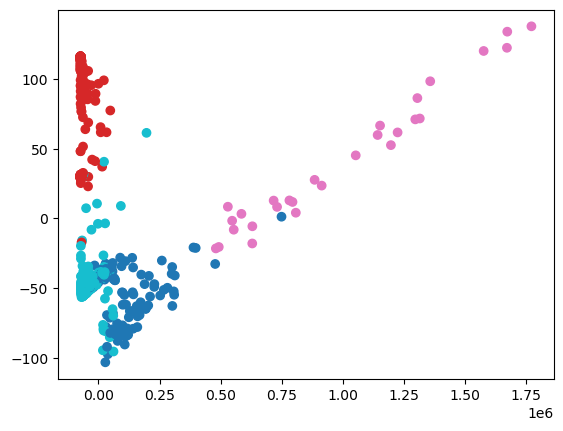

In [22]:
from sklearn.decomposition import PCA
pca_data = PCA(n_components=2).fit_transform(guild_data[['n_talents', 'level', 'n_missions_completed', 'n_characters', 'energy_delta']])
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clustering.labels_, cmap='tab10')

В целом после декомпозиции кластеры хорошо отделяются друг от друга, но полученные два признака неитерпретируемы. Поэтому ниже посмотрим на попарные распределения.

Посмотрим на график кол-во игроков - энергия.      
У кластера самых активных гильдий energy_delta сильно выше, чем у остальных. Так что лучше посмотреть на график с log-шкалой.

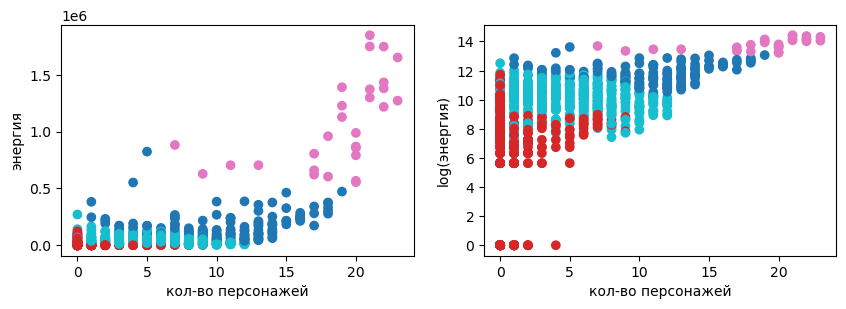

In [23]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.scatter(guild_data['n_characters'], guild_data['energy_delta'], c=clustering.labels_, cmap='tab10')  
plt.ylabel("энергия")
plt.xlabel("кол-во персонажей")
plt.subplot(1, 2, 2)
plt.scatter(guild_data['n_characters'], np.log(guild_data['energy_delta'] + 1), c=clustering.labels_, cmap='tab10')
plt.ylabel("log(энергия)")
plt.xlabel("кол-во персонажей")
plt.show()


Посмотрим на график кол-во игроков - кол-во талантов. Так же в log-шкале.

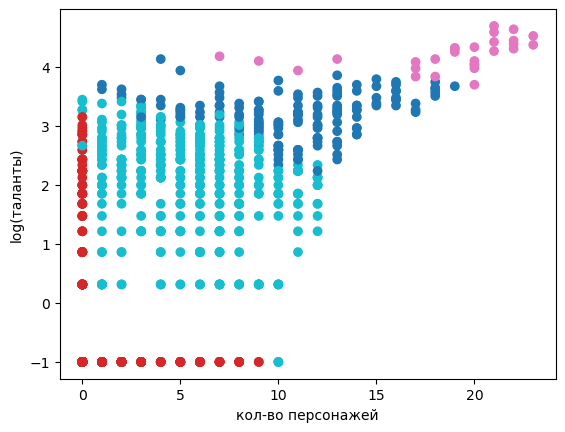

In [24]:
plt.scatter(guild_data['n_characters'], np.log(guild_data['n_talents'] + np.exp(-1)), c=clustering.labels_, cmap='tab10') 
plt.ylabel("log(таланты)")
plt.xlabel("кол-во персонажей")
plt.show()

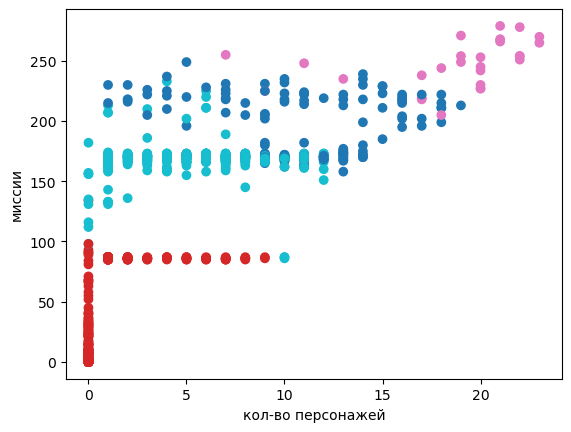

In [25]:
plt.scatter(guild_data['n_characters'], guild_data['n_missions_completed'], c=clustering.labels_, cmap='tab10') 
plt.ylabel("миссии")
plt.xlabel("кол-во персонажей")
plt.show()

## Гипотеза 2: игроки, покупающие премиум товары, создают более активные гильдии

Предлагается расчитать две метрики: 
- Paying share – доля платящих в группе.
- ARPPU (average revenue per paying user) – средняя прибыль с платящего пользователя в группе.


### Шаг 0: загрузка данных

In [26]:
payers = pd.read_csv('payers.csv')
payers

,revenue,character_id
0,102.897877,13642352
1,105.839569,29703528
2,50.040612,28081545
3,18.044814,12663426
4,5.913989,16071934
...,...,...
20425,19.883457,18620449
20426,8.422335,19270498
20427,4.270301,22729767
20428,44.970000,27020854


In [27]:
guild_data['is_premuim'] = guild_data['creator_character_id'].isin(payers['character_id'])

In [28]:
guild_data.to_csv('guild_merged.csv')

In [29]:
guild_data['is_premuim'].value_counts()

False    637
True     328
Name: is_premuim, dtype: int64

Расчитаем paying share

In [30]:
inactive_clusters = clusters[:2].values
active_clusters = clusters[2:].values
clusters

name
Empty          1
Inactive       3
Active         0
Very Active    2
Name: cluster, dtype: int64

### Шаг 1: проверка гипотезы

In [28]:
n_active_premium = guild_data[(guild_data['cluster'].isin(active_clusters)) & (guild_data['is_premuim'] == True)].shape[0]
n_inactive_premium = guild_data[(~guild_data['cluster'].isin(active_clusters)) & (guild_data['is_premuim'] == True)].shape[0]
n_active =  guild_data[guild_data['cluster'].isin(active_clusters)].shape[0]
n_inactive =  guild_data[~guild_data['cluster'].isin(active_clusters)].shape[0]
n_active_premium / n_active, n_inactive_premium /n_inactive

(0.3850267379679144, 0.32904884318766064)

Проверим вторую гипотезу на уровне значимости 5%

$$
H_0: p_0 = p_1
$$
$$
H_1: p_0 > p_1
$$

где $p_0$ - paying share для активных гильдий, а $p_1$ -- неактивных

In [29]:
count = np.array([n_active_premium, n_inactive_premium])
nobs = np.array([n_active, n_inactive])
stat, pval = proportions_ztest(count, nobs, alternative = 'larger')
print('{0:0.3f}'.format(pval))

0.073


Мы не можем отвергнуть гипотезу о равенстве долей платящих на текущем уровне значимости. Скорее всего, что не хватает мощности критерия для данного размера выборки (например, на выборке в 2 раза больше тест бы уверенно отверг $H_0$)

### Шаг 2: проверка доп. гипотезы

Гипотезы нет в ТЗ, но можно проверить, что средняя прибыль от основателей активных гильдий больше, чем от неактивных. (Только из платящих)

$$
H_0: \mu_0 = \mu_1
$$
$$
H_1: \mu_0 > \mu_1
$$

где $\mu_0$ - ARPPU для активных гильдий, а $\mu_1$ -- неактивных

Посчитаем ARPPU 

In [30]:
active = guild_data[guild_data['cluster'].isin(active_clusters)]['creator_character_id']
inactive = guild_data[~guild_data['cluster'].isin(active_clusters)]['creator_character_id']

In [31]:
active_revenue = payers[payers['character_id'].isin(active) & payers['revenue'] != 0]['revenue']
inactive_revenue = payers[payers['character_id'].isin(inactive) & payers['revenue'] != 0]['revenue']
active_revenue.mean(), inactive_revenue.mean()

(77.35542770671339, 49.08317498604529)

<Axes: >

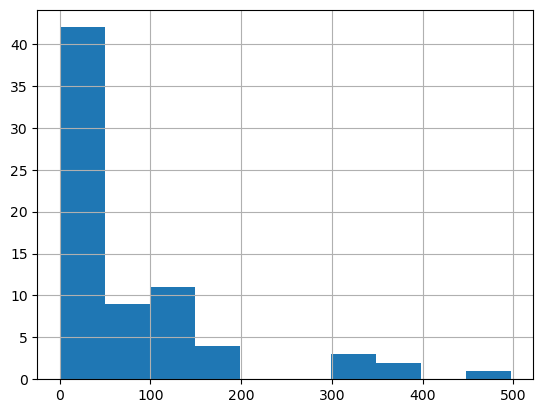

In [32]:
(active_revenue).hist()

Распределения выборок не являются нормальными, но размер выборок достаточно большой для того, чтобы работала ЦПТ

#### A/A test

In [33]:
from typing import Callable
def AA_t_test(data: np.ndarray, n: int) -> float:
    c = 0
    for i in range(n):
        stat, pval, df = ttest_ind(np.random.choice(data, 400), np.random.choice(data, 400), alternative = 'two-sided')
        if pval <= 0.05:
            c += 1
    return c/n

In [34]:
%%time
AA_t_test(active_revenue.values, 10000), AA_t_test(inactive_revenue.values, 10000)

CPU times: total: 5.41 s
Wall time: 5.4 s


(0.0507, 0.048)

In [35]:
def AA_mw_test(data: np.ndarray, n: int) -> float:
    c = 0
    for i in range(n):
        stat, pval = mannwhitneyu(np.random.choice(data, 400), np.random.choice(data, 400), alternative = 'two-sided')
        if pval <= 0.05:
            c += 1
    return c/n

In [36]:
%%time
AA_mw_test(active_revenue.values, 10000), AA_mw_test(inactive_revenue.values, 10000)

CPU times: total: 32 s
Wall time: 32 s


(0.0512, 0.0488)

A/A тест показывает, что тест Стьюдента применим для наших данных и работает быстрее теста Манна-Уитни

Посчитаем p-value

In [37]:
ttest_ind(active_revenue.values, inactive_revenue.values, alternative = 'larger')[1]

0.004082389570644992

Различие статистически и практически значимо, средняя прибыль от основателей активных гильдий больше, чем от неактивных.

### Шаг 3: рассчёт метрик

Посмотрим на paying share в каждой группе

In [38]:
paying_shares = []
for i in range(4):
    n_premium = guild_data[(guild_data['cluster'] == i) & (guild_data['is_premuim'] == True)].shape[0]
    n_total =  guild_data[guild_data['cluster'] == i].shape[0]
    paying_shares.append(n_premium / n_total)
    print(n_premium / n_total, clusters.index[clusters == i].tolist()[0])

0.29395604395604397 Empty
0.34177215189873417 Active
0.6206896551724138 Very Active
0.35990338164251207 Inactive


Также посчитаем ARPPU для каждой группы

In [39]:
ARPPUs = []
for i in range(4):
    group = guild_data[guild_data['cluster'] == i]['creator_character_id']
    mean_revenue = payers[payers['character_id'].isin(group) & payers['revenue'] != 0]['revenue'].mean()
    ARPPUs.append(mean_revenue)
    print(mean_revenue, clusters.index[clusters == i].tolist()[0])

53.15187350669849 Empty
76.94350894477613 Active
78.59118399252513 Very Active
46.680194117097294 Inactive


In [40]:
pd.DataFrame({'paying_share': paying_shares, 'ARPPU': ARPPUs}, index = clusters.sort_values().index)

,paying_share,ARPPU
name,,
Empty,0.293956,53.151874
Active,0.341772,76.943509
Very Active,0.620690,78.591184
Inactive,0.359903,46.680194


Видим, что у активной и очень активной групп средняя прибыль выше, чем у неактивных. Также у очень активной группы гораздо выше доля платящих.

# Заключение

### Гипотеза 1: большинство создаваемых гильдий не активны.  
Гипотеза верна, неактивных гильдий намного больше, чем активных. Разбив гильдии на 4 группы с помощью кластеризации, получаем ~780 неактивных   гильдий против ~190 активных.

### Гипотеза 2: игроки, покупающие премиум товары, создают более активные гильдии.
Гипотезу невозможно подтвердить или опровергнуть на данном объёме       данных. Уровень статистической значимости близок (0.073) к порогу 5%.   Чтобы повысить мощность критерия и получить уверенный ответ, нужно       увеличить  выборку.

### Предложение: стоит ли существенно повысить стоимость создания гильдии
Да, стоит. Опираясь на результаты проверки первой и второй гипотез, можно сказать, что стоимость создания гильдии стоит повысить. Меньше кол-во неактивных гильдий будет стимулировать игроков вступать в гильдии. Также можно  сделать гильдию премиум-товаром, так как по результатам проверки второй гипотезы доли платящих основателей гильдий либо не отличается, либо     отличается несущественно.